# Climate Reconstruction from Real Speleothem Proxies

* Objective:
    - Get the GMT curves for all 5 Models + the Multimodel ensemble.
    - **Objective:** The curves should look similar
    - Test the full Multitimescale (1,5,10,20,40) on the Anomalies, no psm.
    - Use downsampled models first.
    - Play around with the anomaly mean windows (1600 - 1800?). 1900 may already have some global warming in it.

In [10]:
cfg = {
#BASIC PARAMS
'vp':{
'd18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'slp': None,
},
'oro': None,
'reconstruct':['tsurf','d18O','prec'], 
'output_folder':'GMT_from_speleos_normalres', #in cwd
'output_file':'Echam_1_10_20',
'multi_model_prior': None, #None or a list where the first entry is a dictionary of dictionaries for the file paths and secord a dictionary with the orography files
'avg':None, 
'seed': 42, 
'check_nan':False, #mainly needed for iHadCM3, because of its missing years nans are introduced with 'resampled'
###PROXYS
#'obsdata':['/home/mchoblet/paleoda/data/proxy_dbs/sisal_db.nc'],#['/home/mchoblet/paleoda/data/proxy_dbs/sisal_db.nc'],#,'/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db.nc'],
'obsdata':['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1600_1800.nc'],
'obs_var':[['d18O','d18O_precision']],#,['d18O','d18O_precision']], #name of variables and uncertainties in proxy_db files
'proxy_error': [0.1], #irrelevant for PPE
'time_scales': ['median'], 
'proxy_time':['0800','1999'], 
'resample': True,#True,
'resample_mode': 'linear',#'nearest',
'mask': 3, 
###MULTI-TIMESCALE
#'timescales':[1,5,10,20,40], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
#'timescales':[1],
'timescales':[1,5,10,20,40],
'reuse': True,#True, #e.g if a yearly resolved proxy is also to be used in the 5,10 year mean reconstruction
###PSM
'psm':['speleo'], 
'interpol':None, #None/'dw'
'var_psm': ['d18O'] ,
'speleo':{
    'weighting': None,#'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation': False, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'regular'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
},
'icecore':{
    'weighting':'prec', #None(pure d18O) / prec (d180 prec weighted)
    'height': False, #height correction: True requires orography of model and 'elev' coordinate for proxy_db. Requires that proxy_db has a coordinate 'lapse rate' (e.g. i attributed -0.15 to non polar porxies and -0.28 to polar ones (per 100m)
    'filter': False, #If True the PSM-function from PRYSM which takes into account diffusion is applied. 
},
#currently this only works for one Database files, probably at some point that needs to be more flexible
'linear':{
    'variable': 'tsurf' , #variable to regress against
    'type': 'anom' , #absolute value or anomaly
    'anom_time': None , #None for full simulation, or time-list 
    'uniform': None, # if you just want one linear formula to rule them all [slope, intercept]
    #names of the regression parameters in the proxy-db
    'slope': 'slope' ,
    'intercept': 'intercept',
    'error': 'error', #make sure that the error in the database info is really the regression error *variance*, not standard error.
},
###PSEUDOPROXY-EXPERIMENTS (variable comes from var_psm)
'ppe': {
    'use': False,
    'SNR': [5,5], #signal to noise variance ratio
    'noise_type': 'w', #'w'/'r'
    'red_noise_a': 0.32, #autocorrelation for red noise
    'multi_timescale': [[1],[1]], 
    'source': 'external', #internal/external
    'other_model': 
    {'vp':{'tsurf':'/home/ldap-server/draco/cleaned_data/final/CESM_tsurf_850_1850.nc',
    'prec':'/home/ldap-server/draco/cleaned_data/final/CESM_prec_850_1850.nc',
    'd18O':'/home/ldap-server/draco/cleaned_data/final/CESM_d18O_850_1850.nc',
    'evap': '/home/ldap-server/draco/cleaned_data/final/CESM_evap_850_1850.nc'}},
    'oro': '/home/ldap-server/draco/orographies/final/icesm_oro.nc',
    'metrics_ppe': ['Corr','p_value','p_bootstrap','eff_p_value','CE','RMSE','RMSPE','MAE','MAPE'],
    'psm' : {'speleo':{   'weighting':'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation':True, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'regular'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
}, 'icecore': None},
},
    # cfg['ppe']['psm']= {'speleo':None, 'icecore': None} # if the config from above for the psm (which gives the obs-from-model) shall be different for the pseudoproxies.
#else just leave it as {'speleo':None, 'icecore': None} 
    
###KALMAN-FILTER
'time': ['0800','1999'], #covered by all models
'nens':100, #ensemble members
'reps':1, #Monte Carlo
'full_fields': False, 
'proxy_frac': None, #choose 100 random proxies
'extra_assi': 
    {
        'globalmean': ['tsurf','d18O','prec'], #None or list of variables
        'lat_mean': ['tsurf'], #None or list of variables
        'regionalmean': None, #None or list of variables
        'region':None, #None or list of list [[latS,latN],[latW,latE]] #specify the regions in 0-360 longitude system
        'prec_weighted': False, #if you want to get the precipitation weighted d18O
    },
'error_scale':1, 
'anomaly': 'BG+HX', #/ 'HX'
'anomaly_time': ['1600','1800'],#None,#['1500','1750'],#None,
'cov_loc': None,
#evaluation metrics (which do not rely on a true state)
'metrics': [None],#['rank_histogram','rank_histogram_posterior','CD'], #['None']
}

In [3]:
downsampled_paths={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_slp_801_1952.nc',
       }
}

In [4]:
downsampled_paths_nogiss={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_slp_801_1952.nc',
       }
}

In [5]:
import sys
sys.path.append('/home/mchoblet/paleoda')

import xarray as xr
import wrapper
import dataloader
import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature  
from matplotlib.offsetbox import AnchoredText    
import utils

import copy

%load_ext autoreload
%autoreload 2

In [70]:
cfg['full_fields']

False

In [11]:
def experiment_speleo_gmt(paths,cfg,multi_model,multi_model_nogiss):
    """
     - Reconstruction of GMT anomaly (full_fields=False)
     - Anomalies with respect to 1600-1800 (BG + HX)
     - No Psm 
     - 'timescales':[1,5,10,20,40],
     - 'reuse': True,
     - 10 repetitions with 80 percent of the proxies
    """
    cfg['cov_loc']=None
    cfg['reps']=10
    cfg['proxy_frac']=0.8
    for i,p in paths.items():

        cfg=cfg.copy()
        """
        if i=='GISS':
            cfg['cov_loc']=12000
            cfg['full_fields']=True
        else:
            cfg['full_fields']=False
        """
        if i=='iHadCM3':
            cfg['check_nan']=True
        else:
            cfg['check_nan']=False
        
        print(i)
        cfg['check_nan']=True
        cfg['multi_model_prior']=None
        #echange paths
        cfg['vp']=p

        cfg['output_file']=str(i)+'_800_1999'

        wrapper.paleoda_wrapper(cfg)
    
    #multi_model_ensemble
    cfg['multi_model_prior']=multi_model
    cfg['output_file']='mme'+'_800_1999'
    wrapper.paleoda_wrapper(cfg)
    
    #multi_model_ensemble
    cfg['multi_model_prior']=multi_model_nogiss
    cfg['output_file']='mme_nogiss'+'_800_1999'
    wrapper.paleoda_wrapper(cfg)
    
    ##same with mini_r
    #mini-r (give more weight to the proxies)
    cfg['proxy_error']=0.01
    cfg['output_folder']='GMT_from_speleos_minir_normalres'
    
    for i,p in paths.items():

        cfg=cfg.copy()
        """
        if i=='GISS':
            cfg['cov_loc']=12000
            cfg['full_fields']=True
        else:
            cfg['full_fields']=False
        print(i)
        """
        
        if i=='iHadCM3':
            cfg['check_nan']=True
        else:
            cfg['check_nan']=False
            
        cfg['multi_model_prior']=None
        #echange paths
        cfg['vp']=p
        cfg['output_file']=str(i)+'_800_1999'

        wrapper.paleoda_wrapper(cfg)
    
    #multi_model_ensemble
    cfg['multi_model_prior']=multi_model
    cfg['output_file']='mme'+'_800_1999'
    wrapper.paleoda_wrapper(cfg)
    
    #multi_model_ensemble no giss
    cfg['multi_model_prior']=multi_model_nogiss
    cfg['output_file']='mme_nogiss'+'_800_1999'
    wrapper.paleoda_wrapper(cfg)
    

In [ ]:
experiment_speleo_gmt(downsampled_paths,cfg,downsampled_paths,downsampled_paths_nogiss)

iCESM
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:13<00:00,  8.33it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
USING SPELEO PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [06:10<00:00, 37.08s/it]


Finished multitimescale DA
Save variables
Output written to iCESM_800_1999.nc
isoGSM
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:13<00:00,  8.18it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
USING SPELEO PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [06:08<00:00, 36.85s/it]


Finished multitimescale DA
Save variables
Output written to isoGSM_800_1999.nc
Echam
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:13<00:00,  8.18it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
USING SPELEO PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [06:08<00:00, 36.87s/it]


Finished multitimescale DA
Save variables
Output written to Echam_800_1999.nc
GISS
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:14<00:00,  8.06it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
USING SPELEO PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [06:06<00:00, 36.62s/it]


Finished multitimescale DA
Save variables
Output written to GISS_800_1999.nc
iHadCM3
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:14<00:00,  8.02it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced 

100%|██████████| 10/10 [06:07<00:00, 36.79s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3_800_1999.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:14<00:00,  7.99it/s]


Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly 

 30%|███       | 3/10 [12:06<28:15, 242.21s/it]

# Experiments with original model resolution

In [12]:
normal_paths={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc',
       }
}

upsampled_paths_nogiss={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_tsurf_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_slp_801_1952.nc',
       }
}

upsampled_paths={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/upsampled/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_slp_801_1952.nc',
       }
}


In [13]:
experiment_speleo_gmt(normal_paths,cfg,upsampled_paths,upsampled_paths_nogiss)

iCESM
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:13<00:00,  8.31it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
USING SPELEO PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [00:37<00:00,  3.75s/it]


Finished multitimescale DA
Save variables
Output written to iCESM_800_1999.nc
isoGSM
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:13<00:00,  8.11it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
USING SPELEO PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]


Finished multitimescale DA
Save variables
Output written to isoGSM_800_1999.nc
Echam
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:14<00:00,  7.84it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
USING SPELEO PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [01:50<00:00, 11.09s/it]


Finished multitimescale DA
Save variables
Output written to Echam_800_1999.nc
GISS
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:17<00:00,  6.55it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
USING SPELEO PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [03:30<00:00, 21.03s/it]


Finished multitimescale DA
Save variables
Output written to GISS_800_1999.nc
iHadCM3
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:19<00:00,  5.91it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans 

100%|██████████| 10/10 [02:31<00:00, 15.14s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3_800_1999.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:19<00:00,  5.84it/s]


Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_tsurf_851_1850.nc
computing yearly average
USING SP

100%|██████████| 10/10 [42:45<00:00, 256.59s/it]


Finished multitimescale DA
Save variables
Output written to mme_800_1999.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:19<00:00,  5.74it/s]


Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_tsurf_851_1850.nc
computing yearly average
USING SP

100%|██████████| 10/10 [31:42<00:00, 190.28s/it]


Finished multitimescale DA
Save variables
Output written to mme_nogiss_800_1999.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:19<00:00,  5.78it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [03:43<00:00, 22.40s/it]


Finished multitimescale DA
Save variables
Output written to iCESM_800_1999.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:19<00:00,  5.89it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [03:39<00:00, 21.96s/it]


Finished multitimescale DA
Save variables
Output written to isoGSM_800_1999.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:19<00:00,  5.85it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [03:39<00:00, 21.90s/it]


Finished multitimescale DA
Save variables
Output written to Echam_800_1999.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:19<00:00,  5.75it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
USING SPELEO PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [03:51<00:00, 23.19s/it]


Finished multitimescale DA
Save variables
Output written to GISS_800_1999.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:19<00:00,  5.85it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans 

100%|██████████| 10/10 [04:18<00:00, 25.86s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3_800_1999.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:19<00:00,  5.92it/s]


Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_tsurf_851_1850.nc
computing yearly average
USING SP

100%|██████████| 10/10 [39:59<00:00, 239.99s/it]


Finished multitimescale DA
Save variables
Output written to mme_800_1999.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:19<00:00,  5.76it/s]


Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_tsurf_851_1850.nc
computing yearly average
USING SP

100%|██████████| 10/10 [14:34<00:00, 87.46s/it]

Finished multitimescale DA
Save variables
Output written to mme_nogiss_800_1999.nc


In [ ]:
def gmt_together(folder='/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/', names=['Echam','GISS','iCESM','isoGSM','iHadCM3','mme',' mme_nogiss']):
    """
    Which timescales are used? First 1,5,10,20,40
    """
    plt.figure(figsize=(12,8))
    plt.locator_params(nbins=10)
    colors=sns.color_palette('colorblind', n_colors=len(names))
    plt.title('GMT Anomaly using different model priors', fontsize=20)
    
    for i,n in enumerate(names):
        string=folder + n + '_800_1999.nc'
        tsurf=xr.open_dataset(string)['gm_tsurf']
        tsurf=quick_filt(tsurf-tsurf[800:1000].mean('time'),cutoff=1/30)
        #choose different cut off
        std=quick_filt(xr.open_dataset(string)['gm_tsurf_std'],cutoff=1/40)
        plt.plot(tsurf,label=n, color=colors[i])
        plt.fill_between(tsurf, tsurf - std, tsurf + std, color=colors[i], alpha=0.2)
    
    plt.ylabel(r'\Delta T')
    plt.legend(loc='lower right')
    plt.xticks(ticks=np.arange(0,1200,200),labels=list(map(str,np.arange(800,2000,200))))

In [ ]:
def gmt_separate(folder='/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/', names=['Echam','GISS','iCESM','isoGSM','iHadCM3'],paths=downsampled_paths):
    """
    Which timescales are used? First 1,5,10,20,40
    """
    colors=sns.color_palette('colorblind', n_colors=len(names))
    
    for i,n in enumerate(names):
        plt.figure(figsize=(12,8))
        plt.locator_params(nbins=10)
        plt.title(('GMT for model'+n), fontsize=20)
        
        string=folder + n + '_800_1999.nc'
        tsurf=xr.open_dataset(string)['gm_tsurf']
        tsurf=quick_filt(tsurf-tsurf[800:1000].mean('time'))
        std=quick_filt(xr.open_dataset(string)['gm_tsurf_std'],cutoff=1/40)
        plt.plot(tsurf,label='reconstruction', color=colors[i])
        plt.fill_between(tsurf, tsurf - std, tsurf + std, color=colors[i], alpha=0.2)
    
        #load prior model
        tsurf=xr.open_dataset(paths[n]['tsurf'])['tsurf']
        tsurf=utils.globalmean(tsurf)
        tsurf=tsurf-tsurf.sel(time=slice('1600','1800')).mean('time')
    
        plt.plot(tsurf,label='model', color=colors[i])
    
        plt.ylabel(r'\Delta T')
        plt.legend(loc='lower right')
        
        plt.xticks(ticks=np.arange(0,1200,200),labels=list(map(str,np.arange(800,2000,200))))
        plt.show()

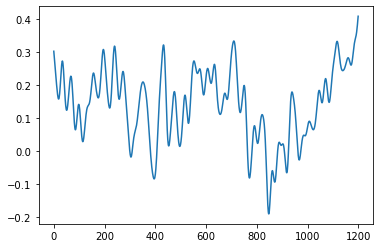

In [56]:
echam=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/iHadCM3_800_1999_0.nc')['gm_tsurf']
plt.plot(quick_filt(echam,cutoff=1/30))

In [35]:
def quick_filt(ts,cutoff=1/30):
    from scipy.signal import butter, lfilter, filtfilt

    def butter_lowpass(cutoff, fs, order=6, kf=1.2):
        # kf:  scaling factor for the lowpass frequency; 1 = Nyquist, 1.2 =
        #' 1.2xNyquist is a tradeoff between reducing variance loss and keeping
        #' aliasing small
        #fs is basic timestep (min_ts)
        #nyquist frequency
        nyq = 0.5 * fs 
        normal_cutoff = cutoff / nyq * kf
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(data, cutoff, fs, order=6):
        #filtfilt does not introduce a time-lag in comparison to butterworth 
        b, a = butter_lowpass(cutoff, fs, order=order)
        y = filtfilt(b, a, data)
        #y = lfilter(b, a, data)
        return y

    return butter_lowpass_filter(ts,cutoff,fs=1,order=4)

In [19]:

/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/GISS_800_1999.nc
/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/iCESM_800_1999.nc
/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/iHadCM3_800_1999.nc
/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/isoGSM_800_1999.nc
/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/mme_800_1999.nc


In [ ]:
def plot_gmt(folder_name,model_names):
    
    

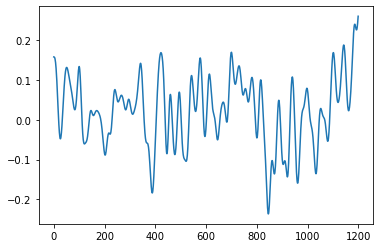

In [38]:
echam=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/Echam_800_1999.nc')['gm_tsurf']
plt.plot(quick_filt(echam,cutoff=1/30))

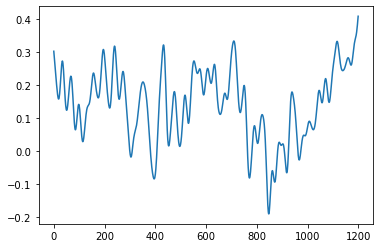

In [57]:
ihad=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/iHadCM3_800_1999_0.nc')['gm_tsurf']
plt.plot(quick_filt(ihad,cutoff=1/30))

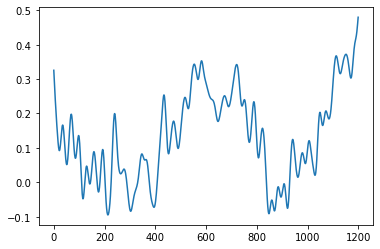

In [58]:
mme=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/mme_800_1999_0.nc')['gm_tsurf']
plt.plot(quick_filt(mme,cutoff=1/30))

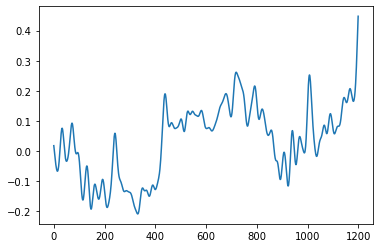

In [39]:
echam=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/GISS_800_1999.nc')['gm_tsurf']
plt.plot(quick_filt(echam,cutoff=1/30))

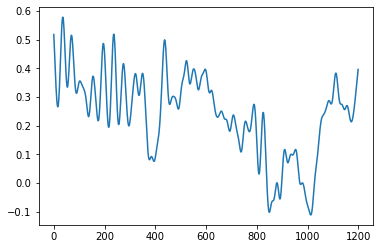

In [40]:
echam=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/iCESM_800_1999.nc')['gm_tsurf']
plt.plot(quick_filt(echam,cutoff=1/30))

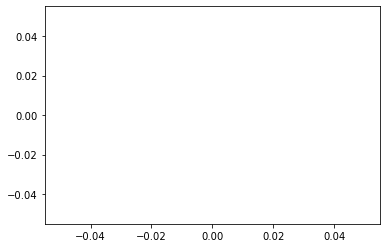

In [41]:
echam=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/iHadCM3_800_1999.nc')['gm_tsurf']
plt.plot(quick_filt(echam,cutoff=1/30))

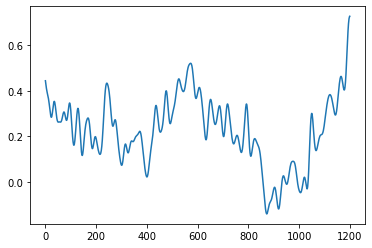

In [43]:
echam=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/isoGSM_800_1999.nc')['gm_tsurf']
plt.plot(quick_filt(echam,cutoff=1/30))

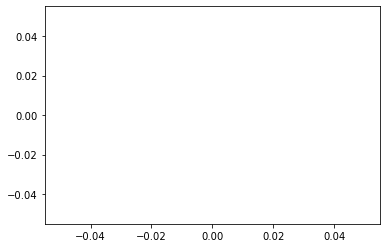

In [44]:
echam=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/mme_800_1999.nc')['gm_tsurf']
plt.plot(quick_filt(echam,cutoff=1/30))